# Programming Assignment 1 - Ridge regression without libraries

CAP 5625 Computational Foundations of AI - Fall 2021 - Dr. DeGiorgio
<br>Christian Garbin

Instructions to run the code are available in the README.md file.

# Setting up the environment

Import the Python modules we use in the notebook and configure the Jupyter environment.

In [1]:
import copy
from typing import Tuple
import numpy as np
import pandas as pd

Import and set up the graphing environment, making plots legible and focusing on trends (not specific values).

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 2})
sns.despine()
%matplotlib inline

Import our ridge regression module and the utilities.

In [3]:
import utils
import ridge

# Ancillary code and definitions

Run the automated tests to verify the code works as intended before we start the expriments.

In [4]:
import test
# Set to true to see each test result
test.verbose = False
test.test_all()
print('All tests passed')

All tests passed


Constants used in the experiments.

In [5]:
LAMBDAS_TO_TEST = [0.01, 0.1, 1, 10, 100, 1_000, 10_000]
NUM_TESTS = len(LAMBDAS_TO_TEST)
LR=0.00001
NUM_FOLDS = 5

Read the dataset and prepare it by encoding categorical columns, standardizing if asked to do so. Note that there is no caching. For a larger dataset we should probably cache it.

Also set constants that depend on the dataset.

In [6]:
FEATURE_NAMES = []

def read_dataset(standardize: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    global FEATURE_NAMES
    
    x, y, FEATURE_NAMES = utils.read_dataset('Credit_N400_p9.csv')

    # Encode the categorical values
    utils.encode_binary_cateogry(x, column=6, one_value='Female')  # gender
    utils.encode_binary_cateogry(x, column=7, one_value='Yes')  # student
    utils.encode_binary_cateogry(x, column=8, one_value='Yes')  # married

    if standardize:
        utils.scale(x)
        utils.center(y)

    return x, y

# Deliverable 1 - effect of lambda on coefficients

> Illustrate the effect of the tuning parameter on the inferred ridge regression coefficients by generating a plot (...) of nine lines (one for each p=9 features), with the y-axis as 𝛽j, j=1,2,...,9, and the x-axis the corresponding log-scaled tuning parameter value log(𝜆) that generated the particular 𝛽.

Perform ridge regression with the different lambda values (takes several seconds to complete).

The large value for `iterations` makes it look closer to figure 6.4 in "An Introduction to Statistical Learning". Lower numbers of iterations (e.g. 10,000) are enough to see the overall trend.

In [7]:
betas = []
for lmbda in LAMBDAS_TO_TEST:
    x, y = read_dataset()
    b = ridge.fit(x, y, lr=LR, lmbda=lmbda, iterations=100_000)
    betas.append(b)

Plot the results, showing how larger values of lambda decrease the coefficients (betas).

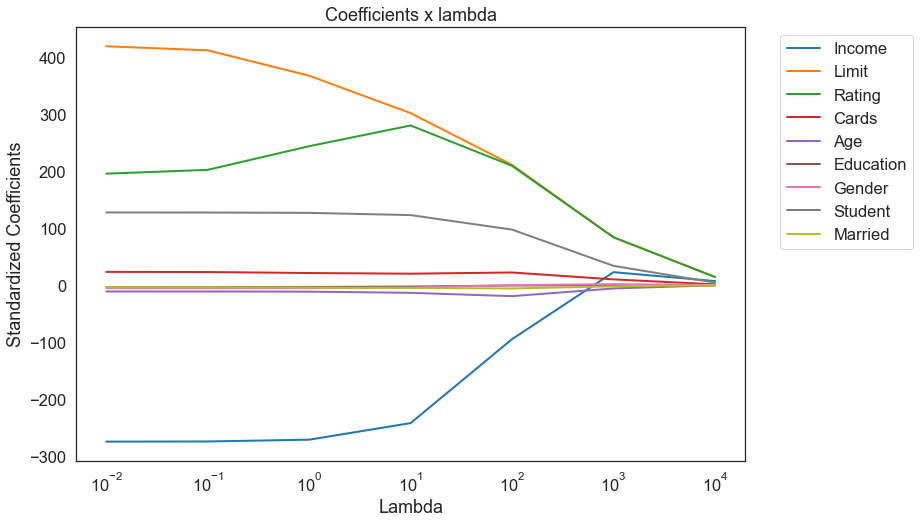

In [8]:
def plot_betas(betas: np.ndarray, title: str):
    # Create a DataFrame in the long format
    df = pd.DataFrame(np.squeeze(betas), columns=FEATURE_NAMES, index=LAMBDAS_TO_TEST)
    df = df.stack().reset_index()
    df.columns = ['Lambda', 'Feature', 'Standardized Coefficients']
    
    # Plot it
    fig, ax = plt.subplots(figsize=(12, 8));
    sns.lineplot(ax=ax, y='Standardized Coefficients', x='Lambda', hue='Feature', data=df)
    ax.set_xscale('log')
    plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
    ax.set_title(title)
    
plot_betas(betas, 'Coefficients x lambda')

# Deliverable 2 - effect of lambda on MSE (with cross validation)

> Illustrate the effect of the tuning parameter on the cross validation error by generating a plot (...) with the y-axis as CV(5) error, and the x-axis the corresponding log-scaled tuning parameter value log(𝜆) that generated the particular CV(5) error.

Perform ridge regression with the different lambda values and cross validation (takes several seconds to complete).

Note that the number of iterations was reduced to keep the run time reasonable.

In [9]:
mse = np.zeros(NUM_TESTS)
for i, lmbda in enumerate(LAMBDAS_TO_TEST):
    x, y = read_dataset(standardize=False)
    fold_mse = np.zeros(NUM_FOLDS)
    for fold in range(1, NUM_FOLDS+1, 1):
        x_train, x_val, y_train, y_val = utils.split_fold(x, y,
                                                          num_folds=NUM_FOLDS,
                                                          fold=fold)
        utils.scale_val(x_train, x_val)
        utils.center_val(y_train, y_val)

        model = ridge.fit(x_train, y_train, lr=LR, lmbda=lmbda, iterations=20_000)
        predictions = ridge.predict(x_val, model)
        fold_mse[fold-1] = utils.mse(y_val, predictions)
    mse[i] = fold_mse.mean()

Plot the results.

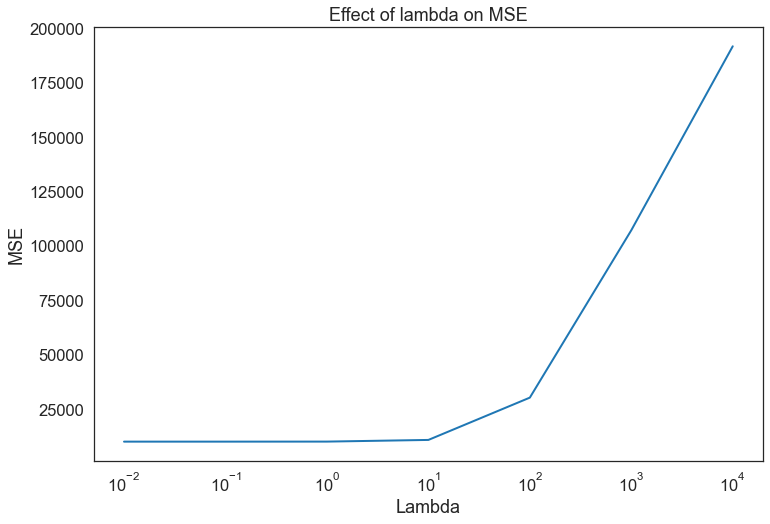

In [10]:
def plot_mse(mse: np.ndarray, title: str):
    # Create a DataFrame in the long format to plot
    df2 = pd.DataFrame([LAMBDAS_TO_TEST, mse]).T
    df2.columns = ['Lambda', 'MSE']
    
    # Plot it
    fig, ax = plt.subplots(figsize=(12, 8));
    sns.lineplot(ax=ax, y='MSE', x='Lambda', data=df2)
    ax.set_xscale('log')
    ax.set_title(title)

plot_mse(mse, 'Effect of lambda on MSE')

# Deliverable 3 - the lambda with the smallest SME

In [11]:
smallest_sme_index = mse.argmin()
smallest_sme_lambda = LAMBDAS_TO_TEST[smallest_sme_index]
print(f'The lambda with the smallest SME is {smallest_sme_lambda}')

The lambda with the smallest SME is 0.01


# Deliverable 4 - model parameters for the lambda with the smallest SME

Train a model with the lambda that resulted in the smallest SME.

In [12]:
x, y = read_dataset()
betas4 = ridge.fit(x, y, lr=LR, lmbda=smallest_sme_lambda, iterations=100_000)

Show the coefficients for this model.

In [13]:
for feature, beta in zip(FEATURE_NAMES, betas4.flatten()):
    print(f'{feature:>10}: {beta:7.2f}')

    Income: -274.65
     Limit:  419.62
    Rating:  195.87
     Cards:   23.45
       Age:  -10.97
 Education:   -3.35
    Gender:   -5.20
   Student:  127.78
   Married:   -3.60


# Deliverable 6 - repeat with a machine learning library

In this section we repeat the experiments above using scikit-learn.

In [14]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import metrics

## Deliverable 6.1 - effect of lambda on coefficients

In [15]:
betas_sk = []
for lmbda in LAMBDAS_TO_TEST:
    x, y = read_dataset(standardize=False)
    model_sk = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      linear_model.Ridge(alpha=lmbda))
    model_sk.fit(x, y)
    coef_sk = model_sk.named_steps['ridge'].coef_
    betas_sk.append(coef_sk)

Plots the results.

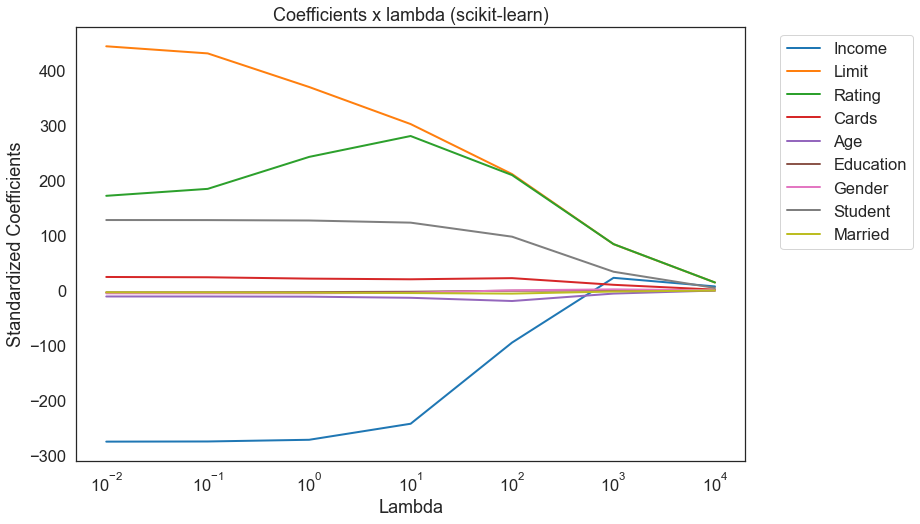

In [16]:
plot_betas(betas_sk, 'Coefficients x lambda (scikit-learn)')

## Deliverable 6.2 - effect of lambda on MSE (with cross validation)

Fit one model for each value of lambda. Ask scikit-learn to store the cross-validation results (`store_cv_values`) so we can calculate the mean SME for each fold.

In [17]:
x, y = read_dataset(standardize=False)
p = pipeline.make_pipeline(preprocessing.StandardScaler(),
                           linear_model.RidgeCV(alphas=LAMBDAS_TO_TEST,
                           store_cv_values=True))
p.fit(x, y)
model_sk = p.named_steps['ridgecv']

# Mean SME for each fold
mse_sk = model_sk.cv_values_.mean(axis=0)

Plot the results.

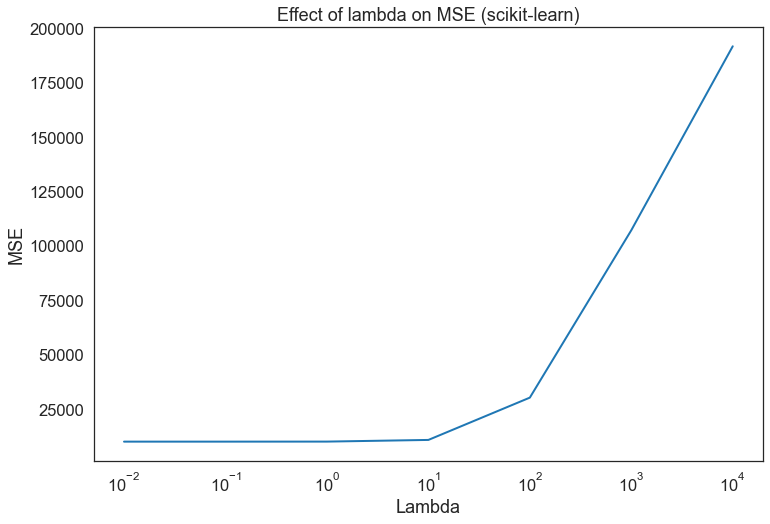

In [18]:
plot_mse(mse, 'Effect of lambda on MSE (scikit-learn)')

## Deliverable 6.3 - the lambda with the smallest SME

In [19]:
print(f'The lambda with the smallest SME is {model_sk.alpha_}')

The lambda with the smallest SME is 0.1


## Deliverable 6.4 - model parameters for the lambda with the smallest SME

In [20]:
x, y = read_dataset(standardize=False)
p = pipeline.make_pipeline(preprocessing.StandardScaler(),
                           linear_model.Ridge(alpha=model_sk.alpha_))
p.fit(x, y)
coef_sk = p.named_steps['ridge'].coef_
for feature, beta in zip(FEATURE_NAMES, coef_sk.flatten()):
    print(f'{feature:>10}: {beta:7.2f}')

    Income: -274.30
     Limit:  430.61
    Rating:  184.52
     Cards:   23.94
       Age:  -10.98
 Education:   -3.40
    Gender:   -5.19
   Student:  127.81
   Married:   -3.52
